# TFM: Xarxes de col·laboració en estudis clínics sobre càncer de mama 
# Alumne: Maria Font Sánchez

## Fase 4: Modelat

L'objectiu d'aquesta implementació es trobar les similituds que hi ha entre els diferents estudis clínics (nodes) del graf mitjançant l'algoritme del coeficient de Jaccard entre dos nodes, i posteriorment establir les comunitats entre els estudis clínics més pròxims entre ells.

## Prerequisits

Aquest Jupyter Notebook s'ha executat amb les següents libreries i versions:
* Python 3.9.13
* Llibreria [Networkx](https://networkx.org/)

Addicionalment, cal disposar del següent fitxer de dades:
1. **clinical_trials.tsv**, obtingut executant l'[endpoint](http://127.0.0.1:5000/tfm-collaboration-network/v1/NetworkCollaboration/insert) de descarrega dels XML de clinicaltrials.gov, transformació de XML a RDF, inserció a GraphDB i posterior creació del TSV amb la relació de nodes adients per a executar la similitud. 

A continació s'importen les llibreries necessaries:

In [24]:
# Llibreries
import networkx as nx
import pandas as pd
import numpy as np
import csv
import requests

## Procés d'execució

### Similituds entre estudis clínics

Es realizarà la lectura del fitxer **clinical_trials.tsv**, aquest fitxer conté la primera fila (fila 0) la capçalera, amb les següents columnes:
* *target*: node inicial de la tripleta, en aquest cas l'identificador de l'estudi clínic amb el patró "ClinicalTrial::IDENTIFICADOR".
* *source*: node final de la tripleta, com són les paraules clau, les condicions o intervencions.
* *weight*: pes de la relació, a tenir en compte per a la detecció de la similitud.

Posteriorment, mitjançant la llibreria Networkx, es transforma l'objecte Pandas de dades a un graf.

In [3]:
PATH_RESULTS = "../../results/clinical_trials.tsv"

In [4]:
# Lectura del fitxer TSV
edgelist = pd.read_csv(PATH_RESULTS, sep='\t', header=0)

# Transformació a graf
clinical_trials_graph = nx.from_pandas_edgelist(edgelist, "target", "source", ["weight"])

edgelist.head(5)

,target,source,weight
0,ClinicalTrial::NCT00001239,Treatment,0.2
1,ClinicalTrial::NCT00001239,FlacWithGm-Csf,1.0
2,ClinicalTrial::NCT00001239,Carcinoma,0.2
3,ClinicalTrial::NCT00001239,Sargramostim,0.3
4,ClinicalTrial::NCT00001239,Leucovorin,0.3


Per tal de trobar la similitud que hi ha entre els diferents estudis clínics, s'executa l'algoritme del [coeficient de Jaccard](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.jaccard_coefficient.html). Aquest algoritme de la llibreria Networkx executa Jaccard entre dos parells de nodes, en aquest cas, per a cada parell d'estudis clínics, i on el resultat de similitud depen del número de propietats que tenen iguals i el número total de propietats entre els dos.

Per exemple, en la imatge següent es mostra que el resultat del coeficient Jaccard és de 0.84, on comparteixen 11 propietats de 13.

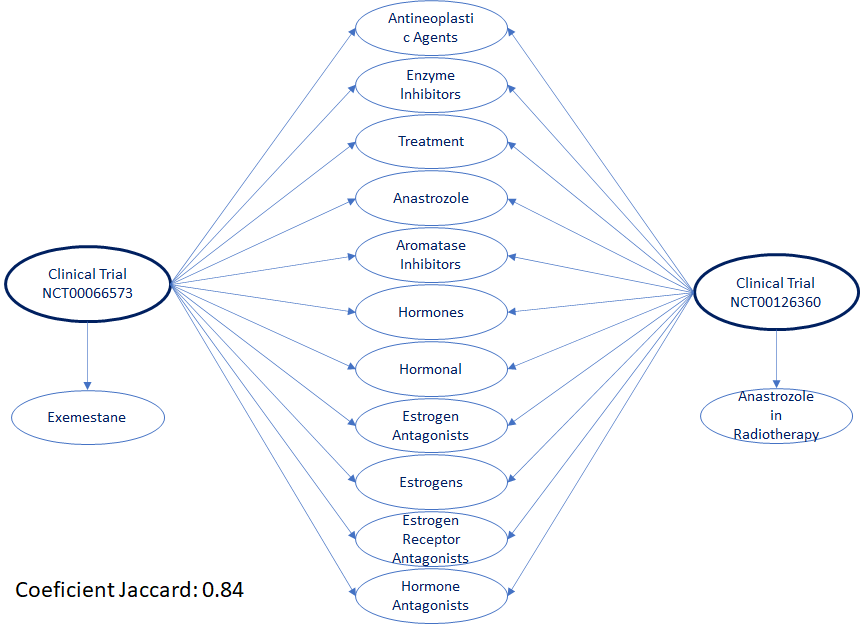

S'executa el coeficient per a cada parell d'estudis clínics que hi ha en el dataset. Tot i així, només es guarden els que tenen una similitud més gran o igual a 0.5.

<div class="alert alert-block alert-warning">
La següent carpeta del GitHub inclou un fitxer amb les similaritats ja calculades. Es pot trobar en el següent <a href="https://github.com/mfontsanc/TFM_CienciaDades/tree/main/results/similarity">enllaç</a>. 
    <br><br>Per tant, es pot realitzar directament la lectura del fitxer i continuar amb el següent pas.
</div>

In [5]:
THRESHOLD = 0.5


def get_jaccard_coefidient(graph):
    """ Mètode que ejecuta el Jaccard coeficient a un graf i retorna les similituds més 
    gran que el threshold i les semblançes entre els estudis clínics.

    Parameters:
        graph: Graf de Networkx

    Returns:
        List: parells d'estudis clínics i el grau de similitud, de forma estructurada.
    """
    result_text = []
    result_structured = []

    results = nx.jaccard_coefficient(graph)
    
    for u, v, p in results:
        # Només es retornen les relacions entre els estudis clínics.
        if u.startswith("ClinicalTrial::") and v.startswith("ClinicalTrial::"):
            # Per damunt el threshold
            if p >= THRESHOLD:
                result_structured.append([u, v, p])
                
    return result_structured

clinical_trials_similarity = get_jaccard_coefidient(clinical_trials_graph)

Es guarda el resultat de la similitud en un fixer CSV per tal de poder utilitzar-ho en la avaluació del model.

In [6]:
PATH_SIMILARITY = '../../results/similarity/clinical_trials_similarity.csv'


with open(PATH_SIMILARITY, 'w', newline='', encoding="utf-8") as f:
    w = csv.writer(f, delimiter=';')
    w.writerow(['ClinicalTrialA', 'ClinicalTrialB', 'Similarity'])

    for ct in clinical_trials_similarity:
        w.writerow(ct)

In [13]:
df_clinical_trials_similarity = pd.read_csv(PATH_SIMILARITY, sep=';')
clinical_trials_similarity = df_clinical_trials_similarity.values.tolist()

<div class="alert alert-block alert-info">
Amb l'execució del procés de similitud, s'han trobat un total de 148,620 parells d'estudis clínics amb similitud igual o superior de 0.6.
</div>

### Cerca de comunitats

Una comunitat està formada per un conjunt d'estudis clínics que són semblants pel que fa a les següents característiques:
* Objectiu de l'estudi: tractament o observacional.
* Tipus d'intervenció.
* Condició de salud que s'està estudiant.
* Les paraules clau extretes de forma automàtica i que utilitzen la taxonomia Mesh.

<br>Tots els estudis clínics d'una mateixa comunitat han de tenir una similitud igual o superior a 0.6.

<br>A continuació es mostra el procés de cerca de comunitats, i posteriorment la mateixa implementació:
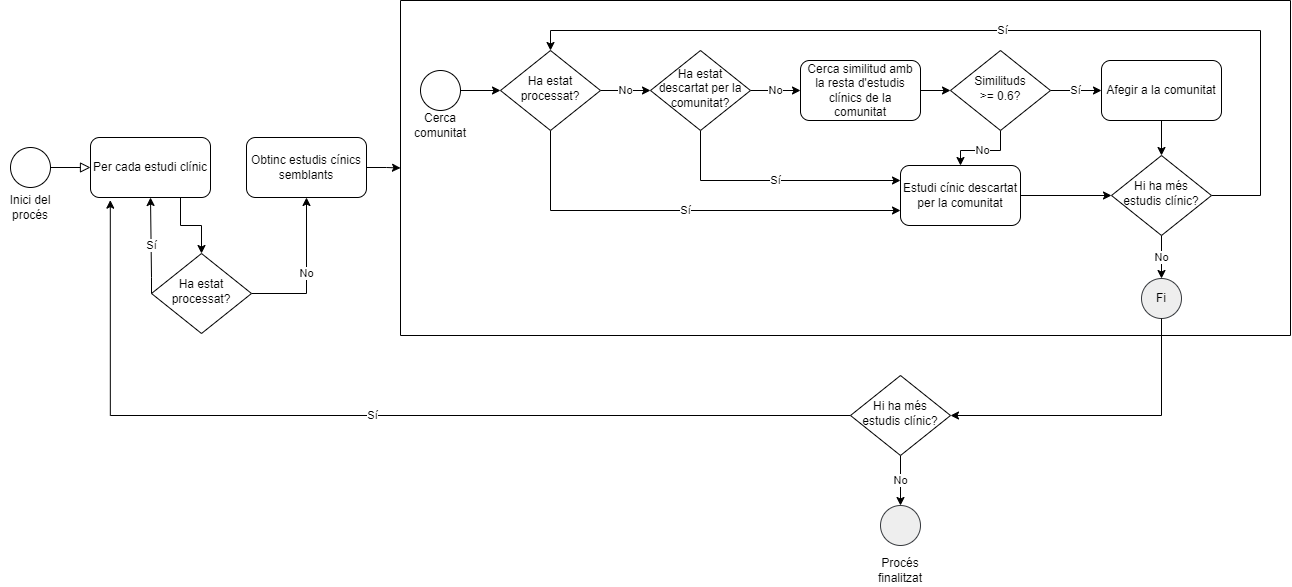

<div class="alert alert-block alert-warning">
La següent carpeta del GitHub inclou un fitxer comprimir amb les comunitats ja calculades. Es pot trobar en el següent <a href="https://github.com/mfontsanc/TFM_CienciaDades/blob/main/results/communities.zip">enllaç</a>. 
</div>

In [22]:
PATH_DESTINATION_COMMUNITIES = '../../results/communities/'

clinical_trial_processed = []
list_communities = {}
community_id = 0

THRESHOLD = 0.6

def get_community(current_clinical_study, current_community):
    """ Mètode recursiu per a obtenir la comunitat a partir d'un estudi clínic.

    Parameters:
        current_clinical_study (str): Identificador de l'estudi clínic concret.
        current_community (list): Llistat amb els estudis clínics que pertanyen a una comunitat.

    Returns:
        List: Llistat amb els estudis clínics que pertanyen a una comunitat.
    """
    
    # Estudis clínics similars al current_clinical_study, que no s'hagin processat ni descartat per aquesta comunitat.
    communities_a = [x[1] for x in clinical_trials_similarity 
                     if x[0] == current_clinical_study and x[2] >= THRESHOLD 
                     and x[1] not in clinical_trial_processed 
                     and x[1] not in clinical_trials_discarded_community 
                     and x[1] not in current_community]
    
    communities_b = [x[0] for x in clinical_trials_similarity 
                     if x[1] == current_clinical_study and x[2] >= THRESHOLD 
                     and x[0] not in clinical_trial_processed 
                     and x[0] not in clinical_trials_discarded_community 
                     and x[0] not in current_community]
    
    communities = communities_a + communities_b if len(communities_b)>1 else communities_a
    
    for community in communities:
        if community not in clinical_trials_discarded_community and community not in current_community:
            continue_process = True

            # Validem que l'estudi clínic similar, també sigui similar amb els altres estudis clínics dins de la comunitat
            for community_processed in current_community:
                if community_processed != current_clinical_study and community_processed not in clinical_trials_discarded_community:
                    score = [x[2] for x in clinical_trials_similarity 
                             if (x[0] == community and x[1] == community_processed)
                             or (x[1] == community and x[0] == community_processed)]

                    score = score[0] if len(score)>0 else 0

                    if score < THRESHOLD:
                        continue_process = False

            if continue_process:
                current_community.append(community)
                get_community(community, current_community)
            else:
                clinical_trials_discarded_community.append(community)
            
    return current_community
                    

for triple in clinical_trials_similarity:
    # Extrec l'identificador de l'estudi clínic.
    clinical_trial = triple[0]
    
    clinical_trials_discarded_community = []
    # Si l'estudi clínic encara no ha estat processat, continuo.
    if clinical_trial not in clinical_trial_processed:
        # Genero la comunitat, amb l'estudi clínic com el primer de la comunitat.
        list_community = [clinical_trial]
        # Obtinc altres estudis clínics similars per a la comunitat.
        list_community = get_community(clinical_trial, list_community)
        
        # Si la funció get_community retorna un altre estudi clínic, es genera la comunitat.
        # Sinó es descarta.
        clinical_trial_processed = clinical_trial_processed + list_community if len(list_community)>0 else clinical_trial_processed

        # Guardo els estudis clínics de la comunitat en un fitxer.
        if len(list_community) > 1:
            filename = PATH_DESTINATION_COMMUNITIES + str(community_id) + '.txt'
            with open(filename, 'w', encoding='utf-8') as f:
                for r in list_community:
                    f.write(r) 
                    f.write('\n')

            community_id += 1
            list_community = []
            clinical_trials_discarded_community = []

<div class="alert alert-block alert-info">
El resultat de la cerca de comunitats és de 1,062 comunitats.
</div>

A continuació, les relacions entre els diferents estudis clínics i el número de comunitat, s'afegirà a la base de dades.

In [27]:
API_URL = "http://127.0.0.1:5000/tfm-collaboration-network/v1/NetworkCollaboration/insert_communities"

headers = {
    "accept": "application/json",
    "Content-Type": "application/json",
}

params = {
    "folder_path": os.path.abspath(PATH_DESTINATION_COMMUNITIES)
}

r=requests.post(url = API_URL, headers = headers, json = params)

print("Response: " + r.json()['message'])

Response: ['The save of communities TXT information has ended successfully.', 'The generation of community triples has ended successfully.', 'The insertion of community triples into GraphDB has ended successfully.', 'Process ended']
